In [80]:
%pylab notebook

import rasterio.features
from shapely.geometry import Polygon, shape, mapping
from shapely.ops import unary_union
import geopandas as gp
import fiona
from fiona.crs import from_epsg
import xarray as xr
import glob
import os.path

from shapely.geometry import asShape
from shapely.geometry import MultiPolygon, Polygon

import dask
from distributed import Client, LocalCluster

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shape', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [64]:
# cluster = LocalCluster(local_dir='/local/u46/adh547/tmp')
cluster = LocalCluster(local_dir='/g/data/u46/users/ext547/ewater/working')

client = Client(cluster)
dask.config.set(get=client.get)
client

Client Scheduler: tcp://127.0.0.1:37825 Dashboard: http://127.0.0.1:38387/status,Cluster Workers: 8 Cores: 8 Memory: 33.67 GB


In [67]:
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    data = rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)
    coords = [xr.DataArray(data=coord.values, name=dim, dims=[dim], attrs={'units': coord.units}) 
              for dim, coord in geobox.coords.items()]
    return xarray.DataArray(data, coords=coords)

In [68]:
def get_shapes(shape_file):
    with fiona.open(shape_file) as shapes:
        crs = datacube.utils.geometry.CRS(shapes.crs_wkt)
        for shape in shapes:
            geom = datacube.utils.geometry.Geometry(shape['geometry'], crs=crs)
            yield geom, shape['properties']

In [104]:
# with fiona.open(WOFSshp) as shapes:
#     crs = datacube.utils.geometry.CRS(shapes.crs_wkt)
#     geom = datacube.utils.geometry.Geometry(shapes['geometry'], crs=crs)
# #     yield geom, shape['properties']

In [105]:
# crs = datacube.utils.geometry.CRS(test.crs_wkt)
# geom = datacube.utils.geometry.Geometry(test, crs=crs)
# #             yield geom, shape['properties']

In [69]:
AtLeastThisWet  = 0.25

In [70]:
MinSize = 6300
MaxSize = 1000000000

In [71]:
from datacube import Datacube


In [72]:
cdc = Datacube(config='/g/data/u46/users/ext547/ewater/cambodia_cube/cambodia.conf')


In [73]:
# Where are the datacube-stats netCDF files located?# Where 
WOFSRasterFolder = '/g/data/u46/users/ext547/ewater/input_data/test/'

# The name and filepath of the final output polygon set
WOFSshp = '/g/data/u46/users/ext547/ewater/input_data/water_body/HydroLAKES_KHM_SHp/TonleSap_buffer.shp'

# # Read in the major rivers dataset (if you are using it)
# FilteredMajorRivers = '/g/data/r78/cek156/ShapeFiles/SurfaceHydrologyLinesRegionalFilteredMAJOR.shp'
# MajorRivers = gp.GeoDataFrame.from_file(FilteredMajorRivers)

In [74]:
Alltiles  = glob.glob('{0}*.tif'.format(WOFSRasterFolder))

In [75]:
FilterOutRivers = False

In [128]:
shapes = get_shapes(WOFSshp)
WOFSlake = {}

for WOFSfile in Alltiles: 
    # Save WOFS year info from name
    WOFSyear = WOFSfile[-12:-8]
    # Read in the data
    WOFSRasterData = xr.open_rasterio(WOFSfile)
#     print(WOFSRasterData)
    # Filter our classified data layer to remove noise
    # Remove any pixels that are wet < 10% of the time
    WOFSfiltered = WOFSRasterData > AtLeastThisWet
    WOFSfiltered = WOFSfiltered.squeeze()
    # Change all zeros to NaN
    WOFSfiltered = WOFSfiltered.where(WOFSfiltered !=0)
    
    for geometry, properties in shapes:
        geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry, hi_resolution, crs=None, align=None)
        mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
        print(mask)
        WOFSArray = WOFSfiltered.where(mask)
        print(WOFSArray)
        WOFSlake[WOFSyear] = WOFSArray
print(WOFSlake)

<xarray.DataArray (latitude: 1, longitude: 1)>
array([[ True]])
Coordinates:
  * latitude   (latitude) float64 15.0
  * longitude  (longitude) float64 105.0
<xarray.DataArray (y: 4071, x: 3993, latitude: 1, longitude: 1)>
array([[[[ 1.]],

        ...,

        [[nan]]],


       ...,


       [[[nan]],

        ...,

        [[ 1.]]]])
Coordinates:
    band       int64 1
  * y          (y) float64 1.493e+06 1.493e+06 1.493e+06 1.493e+06 1.493e+06 ...
  * x          (x) float64 3.369e+05 3.37e+05 3.37e+05 3.37e+05 3.371e+05 ...
  * latitude   (latitude) float64 15.0
  * longitude  (longitude) float64 105.0
{'2011': <xarray.DataArray (y: 4071, x: 3993, latitude: 1, longitude: 1)>
array([[[[ 1.]],

        ...,

        [[nan]]],


       ...,


       [[[nan]],

        ...,

        [[ 1.]]]])
Coordinates:
    band       int64 1
  * y          (y) float64 1.493e+06 1.493e+06 1.493e+06 1.493e+06 1.493e+06 ...
  * x          (x) float64 3.369e+05 3.37e+05 3.37e+05 3.37e+05 3.371e+05 ...


<IPython.core.display.Javascript object>


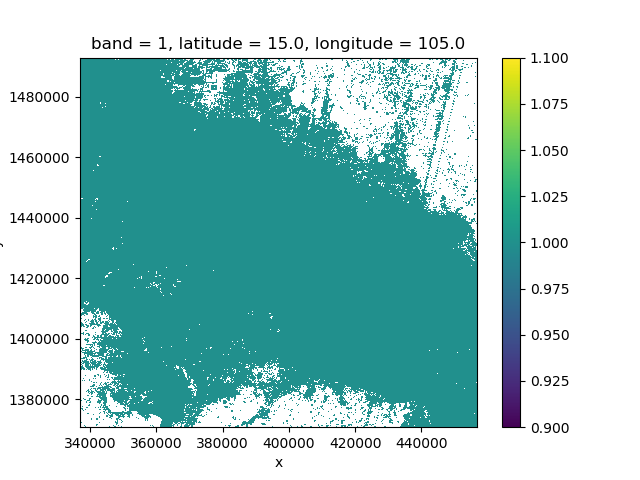

In [123]:
WOFSlake['2011'].plot()

In [77]:
shapes = get_shapes(WOFSshp)

In [78]:
crs = WOFSRasterData.crs
resolution = WOFSRasterData.res

upsample = 1
hi_resolution = [r * upsample for r in resolution]
hi_resolution

[30.0, 30.0]

In [81]:
import xarray

In [107]:
shapes = get_shapes(WOFSshp)
for geometry, properties in shapes:
    geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry, hi_resolution, crs=None, align=None)
    mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
    WOFSArray = WOFSfiltered.where(mask)
    WOFSlake[] = 
print(WOFSArray)

<xarray.DataArray (y: 4071, x: 3993, latitude: 1, longitude: 1)>
array([[[[ 1.]],

        ...,

        [[nan]]],


       ...,


       [[[nan]],

        ...,

        [[ 1.]]]])
Coordinates:
    band       int64 1
  * y          (y) float64 1.493e+06 1.493e+06 1.493e+06 1.493e+06 1.493e+06 ...
  * x          (x) float64 3.369e+05 3.37e+05 3.37e+05 3.37e+05 3.371e+05 ...
  * latitude   (latitude) float64 15.0
  * longitude  (longitude) float64 105.0


In [58]:
# for  WOFSfile in Alltiles: 
#     # Read in the data
#     WOFSnetCDFData = xr.open_rasterio(WOFSfile)
#     # Filter our classified data layer to remove noise
#     # Remove any pixels that are wet < 10% of the time
#     WOFSfiltered = WOFSnetCDFData > AtLeastThisWet
#     # Remove the superfluous time dimension
# #     WOFSfiltered = WOFSfiltered.squeeze()
# #     # Change all zeros to NaN
# #     WOFSfiltered = WOFSfiltered.where(WOFSfiltered !=0)

# #     # Convert the raster to polygons
# #     WOFSpolygons = rasterio.features.shapes(WOFSfiltered.data.astype('float32'), 
# #                                             transform = WOFSnetCDFData.transform[:-3])
# #     WOFSlist = list(WOFSpolygons)

# #     # Calculate the area of each polygon
# #     WOFLshapes = []
# #     for i, WOFLshape in enumerate(WOFSlist):
# #         polyArea = Polygon(WOFLshape[0]['coordinates'][0]).area
# #         WOFLshape[0]['properties'] = {'area': polyArea}
# #         WOFLshapes.append(WOFLshape)

# #     # Filter out any polygons smaller than MinSize, and greater than MaxSize
# #     AreasIndex = [i for i, x in enumerate(WOFLshapes) if 
# #                   (x[0]['properties']['area'] > MinSize) & 
# #                   (x[0]['properties']['area'] < MaxSize)]
# #     WOFSOFSbig = [WOFLshapes[x] for x in AreasIndex]

# #     WOFSOFSbreaktuple = [a for a, b in list(WOFSOFSbig)]
# #     for poly in WOFSOFSbreaktuple:
# #         poly['geometry'] = shape(poly)
# #     if FilterOutRivers:
# #         # Remove any polygons that intersect with a major river
# #         # We are only interested in farm dams, so do not need the WOFS polygons for the rivers. 
# #         # Grab the geometries


# #         WOFSOFSfiltered2p0 = gp.GeoDataFrame(WOFSOFSbreaktuple).set_geometry('geometry')
# #         Intersections= gp.sjoin(MajorRivers, WOFSOFSfiltered2p0, how="inner", op='intersects')
# #         IntersectIndex = sorted(list(set(Intersections['index_right'])))

# #         WOFSOFS = [WOFSOFSbreaktuple[x] for x in range(len(WOFSOFSbreaktuple)) 
# #                                           if x not in IntersectIndex]
# #     else:
# #         WOFSOFS = WOFSOFSbreaktuple

# #     # Merge any overlapping polygons 
# #     MergedPolygonsGeoms = unary_union([feature['geometry'] for feature in WOFSOFS])
# #     MergedPolygonsGeomsList = list(MergedPolygonsGeoms)

# #     # Re-calculate the area of each polygon and add it as an attribute to our new merged polygons
# #     #( For some reason, doing this merge prior to filtering doesn't work properly, hence calculating
# #     # area twice...)
# #     MergedPolygons = []
# #     for i, WOFLshape in enumerate(MergedPolygonsGeomsList):
# #         PolygonBits = mapping(WOFLshape)
# #         polyArea = Polygon(WOFLshape).area
# #         PolygonBits['properties'] = {'area': polyArea}
# #         MergedPolygons.append(PolygonBits)

# #     # Save the polygons to a shapefile
# #     schema = {'geometry': 'Polygon','properties': {'area': 'str'}}

# #     if os.path.isfile(WOFSshp):
# #         with fiona.open(WOFSshp, "a", crs = from_epsg(3577), driver = 'ESRI Shapefile', schema = schema) as output:
# #             for i in range(len(MergedPolygons)):
# #                 output.write({'properties': {'area': MergedPolygons[i]['properties']['area']},
# #                             'geometry': {'type': MergedPolygons[i]['type'], 'coordinates': MergedPolygons[i]['coordinates']}})
# #     else:
# #         with fiona.open(WOFSshp, "w", crs = from_epsg(3577), driver = 'ESRI Shapefile', schema = schema) as output:
# #             for i in range(len(MergedPolygons)):
# #                 output.write({'properties': {'area': MergedPolygons[i]['properties']['area']},
# #                             'geometry': {'type': MergedPolygons[i]['type'], 'coordinates': MergedPolygons[i]['coordinates']}})